# Building an agent-based model from scratch: Money agents

For details of this example see: https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/Users/sivanujanselvarajah/Documents/zhaw/4.Semester/Scientific programming/scientific_programming/Week_09/exercises


## Create an agent class

In [2]:
# MoneyAgent class
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    # Method to move the agent on the grid
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    # Method to give money to other agents
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    # Step method (action the agent takes when it is activated by the schedule)
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

## Function for the calculation of the Gini coefficient

In [3]:
# Function to calculate the Gini coefficient (measure of wealth inequality)
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

## Create a model class

In [4]:
# MoneyModel class
class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        # Scheduler (controls the order in which agents are activated)
        self.schedule = RandomActivation(self)

        # Create agents using MoneyAgent class
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Data collector (for Gini coefficient see function compute_gini())
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Create a model and define the model parameters

In [5]:
# Create a model with 400 agents on a 20x20 grid, and run it for 100 steps
model = MoneyModel(400, 20, 20)
n_steps = 100

# Create model iterations
for i in range(n_steps):
    model.step()

## Visualize the number of agents on the grid

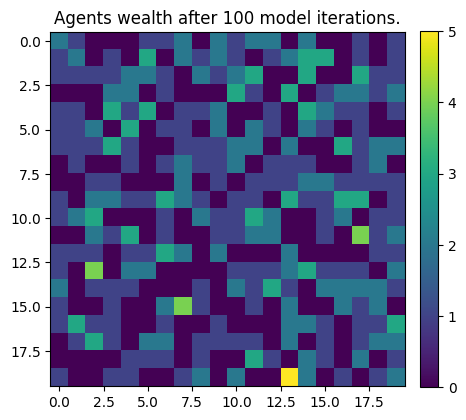

In [6]:
# Count agents
agent_counts = np.zeros((model.grid.width, model.grid.height))

for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count

# Plot results
plt.figure(figsize=(5,5))
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(f"Agents wealth after {n_steps} model iterations.")

plt.show()

## Plot Gini coefficient per step

<Axes: title={'center': 'Gini coefficient per step'}, xlabel='Step', ylabel='Gini coefficient'>

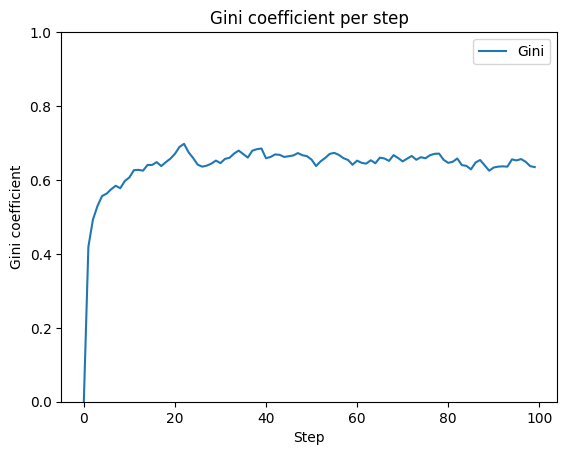

In [7]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot(xlabel='Step', 
          ylabel='Gini coefficient', 
          title='Gini coefficient per step',
          ylim=(0,1))

## Show wealth of all agents after model run

In [8]:
# Show wealth of all agents
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   395           0
     396           0
     397           0
     398           3
     399           2

[40000 rows x 1 columns]

## Line chart of a single agent's wealth per model step

<Axes: title={'center': "Single agent's wealth per model step"}, xlabel='Step', ylabel='amount of money'>

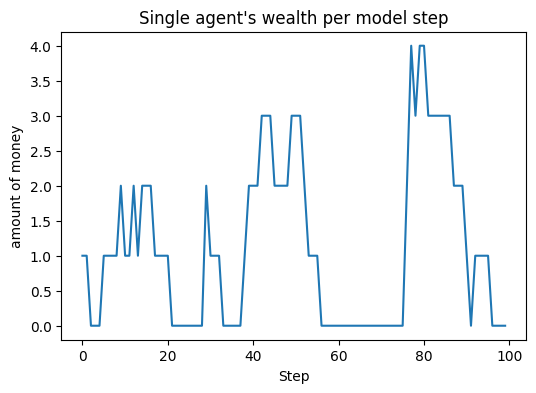

In [9]:
# Wealth of a single agent (agent 5 in this case)
one_agent_wealth = agent_wealth.xs(5, level="AgentID")
one_agent_wealth.Wealth.plot(figsize=(6,4), 
                             xlabel='Step',
                             ylabel='amount of money', 
                             title="Single agent's wealth per model step")

## Distribution of wealth after model run

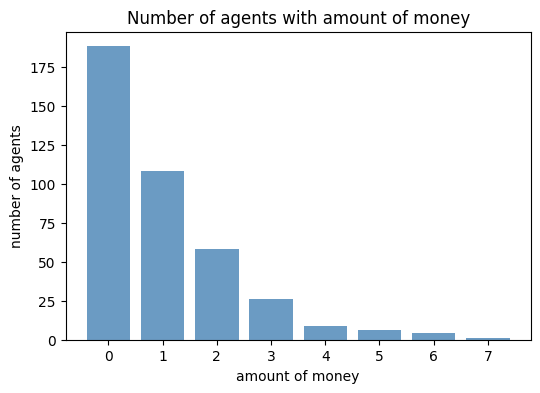

In [10]:
# Distribution of wealth after model run 
end_wealth = agent_wealth.xs(n_steps - 1, level="Step")["Wealth"]
end_wealth

# Values
df_bar = end_wealth.value_counts()
num_agents = list(df_bar)
wealth = list(df_bar.index.values)
y_pos = np.arange(len(wealth))

# Bar chart
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(y_pos, num_agents, align='center', color='steelblue', alpha=0.8)
ax.set_title('Number of agents with amount of money')
ax.set_xlabel('amount of money')
ax.set_ylabel('number of agents')

# Show graph
plt.show()


### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [11]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 23.3.0
Datetime: 2024-04-19 17:06:40
Python Version: 3.10.13
-----------------------------------
